In [1]:
import json
import pandas as pd
import os

def map_images_to_captions(image_dir, json_file):
    # Load JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    if isinstance(data, dict) and 'annotations' in data:
        annotations = data['annotations']  # Extract the list of annotations
    elif isinstance(data, list):
        annotations = data  # If it's already a list, use it directly
    else:
        raise ValueError("Unexpected JSON format")

    image_caption_list = []

    for entry in annotations:
        image_id = entry['image_id']
        caption = entry['caption']
        
        # Format image filename by replacing the last 6 digits with image_id
        image_filename = f"COCO_train2014_{image_id:012d}.jpg"
        image_path = os.path.join(image_dir, image_filename)

        image_caption_list.append((image_path, caption))

    # Create DataFrame
    df = pd.DataFrame(image_caption_list, columns=['image_path', 'caption'])
    return df

# Define paths
image_dir = "/mnt/c/Users/ASUS/Downloads/cocomini/Images"
json_file = "/mnt/c/Users/ASUS/Downloads/cocomini/captions.json"

# Create DataFrame
df = map_images_to_captions(image_dir, json_file)
df.to_csv("training_data.csv", index=False)

dataset = pd.read_csv("training_data.csv")
dataset.head()

,image_path,caption
0,/mnt/c/Users/ASUS/Downloads/cocomini/Images/CO...,A white square kitchen with tile floor that ne...
1,/mnt/c/Users/ASUS/Downloads/cocomini/Images/CO...,"A surfer, a woman, and a child walk on the beach."
2,/mnt/c/Users/ASUS/Downloads/cocomini/Images/CO...,A few people sit on a dim transportation system.
3,/mnt/c/Users/ASUS/Downloads/cocomini/Images/CO...,"A person, protected from the rain by their umb..."
4,/mnt/c/Users/ASUS/Downloads/cocomini/Images/CO...,The bathroom with a toilet has an interesting ...


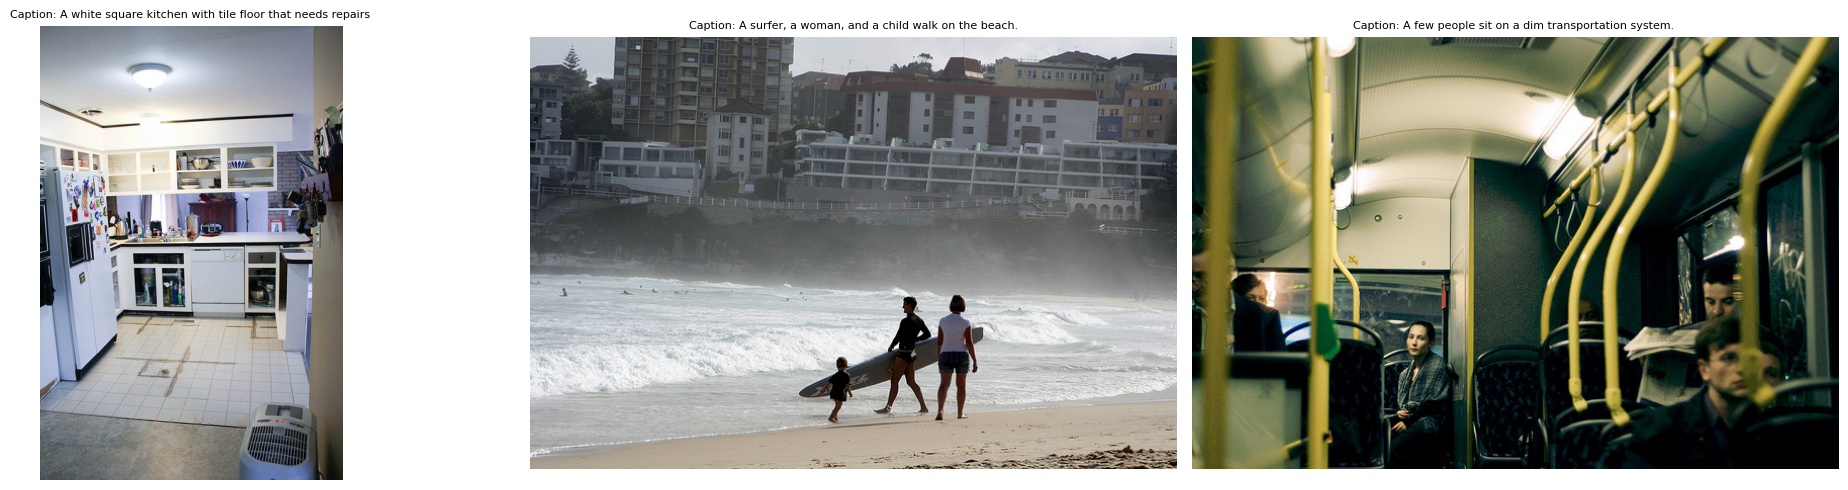

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Function to display an image with its caption
def show_image_with_caption(image_path, df):
    # Find the row in the DataFrame with the given image path
    row = dataset[dataset['image_path'] == image_path]

    if row.empty:
        print("Image not found in the dataset.")
        return
    
    caption = row['caption'].values[0]  # Extract the caption
    
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Caption: {caption}")
    plt.show()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for idx, ax in enumerate(axes):
    image_path = dataset['image_path'][idx]
    row = dataset[dataset['image_path'] == image_path]

    if row.empty:
        ax.axis("off")
        continue

    caption = row['caption'].values[0]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Caption: {caption}", fontsize=8)
plt.tight_layout()
plt.show()



In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Reshape, Input
from tensorflow.keras.models import Model

def build_encoder(image_shape=(224, 224, 3), feature_dim=256):
    # Load pre-trained ResNet50 without the top layers; we want the convolutional features.
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=image_shape)
    base_model.trainable = False  # Optionally freeze base model during initial training

    # The output of ResNet50 will have shape (7, 7, 2048) for 224x224 images.
    x = base_model.output
    # Reshape the features so that we have a sequence of feature vectors, one per spatial location.
    # Here 7x7 = 49 spatial locations.
    x = Reshape((49, 2048))(x)
    # Project the features to a desired embedding dimension (e.g. 256).
    features = Dense(feature_dim, activation='relu')(x)
    
    encoder_model = Model(inputs=base_model.input, outputs=features)
    return encoder_model

# Create the encoder
encoder = build_encoder()
encoder.summary()


2025-04-09 04:54:58.222152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744174498.486820    2367 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744174498.559882    2367 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744174499.124964    2367 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744174499.125027    2367 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744174499.125035    2367 computation_placer.cc:177] computation placer alr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,256 (91.98 MB)

 Trainable params: 524,544 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)     # Applied on features
        self.W2 = Dense(units)     # Applied on decoder hidden state
        self.V = Dense(1)          # Produces a score for each feature vector

    def call(self, features, hidden):
        # hidden: [batch_size, hidden_dim] → add time axis: [batch_size, 1, hidden_dim]
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # Calculate the score using a feed-forward network:
        # score shape: [batch_size, 49, units]
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # score shape becomes: [batch_size, 49, 1]
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        # Multiply and sum the features weighted by their attention coefficients.
        context_vector = attention_weights * features  # shape: (batch_size, 49, feature_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # shape: (batch_size, feature_dim)
        return context_vector, attention_weights


In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, attention_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Here we use a bidirectional LSTM. In practice, you might use a unidirectional LSTM for auto-regressive generation.
        self.bi_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(dec_units, return_sequences=True, return_state=True)
        )
        self.attention = BahdanauAttention(attention_units)
        self.fc1 = Dense(dec_units, activation='relu')
        self.fc2 = Dense(vocab_size)  # Final output layer for predicting the next word.

    def call(self, x, features, hidden_state):
        # x: current input token indices of shape (batch_size, 1)
        # features: encoded image features, shape (batch_size, 49, feature_dim)
        # hidden_state: current hidden state for attention (shape: [batch_size, dec_units] or [batch_size, 2*dec_units] if using bidirectional)
        
        # Embed the input tokens
        x = self.embedding(x)  # shape becomes: (batch_size, 1, embedding_dim)

        # Compute attention: the attention layer returns a context vector and attention weights.
        context_vector, attention_weights = self.attention(features, hidden_state) 
        # Expand context_vector to concatenate with embedded word: (batch_size, 1, feature_dim)
        context_vector = tf.expand_dims(context_vector, 1)

        # Combine the embedded input with the context vector.
        # The idea is to inform the RNN of which parts of the image to attend to.
        x = tf.concat([context_vector, x], axis=-1)  # shape: (batch_size, 1, embedding_dim + feature_dim)

        # Process the sequence with a bidirectional LSTM
        lstm_output, forward_h, forward_c, backward_h, backward_c = self.bi_lstm(x)
        # Combine the forward and backward hidden states (you could also handle the states separately)
        combined_hidden = tf.concat([forward_h, backward_h], axis=-1)
        
        # Pass the output of the LSTM through a dense network.
        x = self.fc1(lstm_output)  # shape: (batch_size, 1, dec_units)
        x = tf.reshape(x, (-1, x.shape[2]))  # flatten time dimension for prediction
        x = self.fc2(x)  # shape: (batch_size, vocab_size)
        
        # Return predictions, the new combined hidden state, and attention weights for visualization/analysis.
        return x, combined_hidden, attention_weights

# Example hyperparameters:
vocab_size = 5000    # modify as per your dataset vocabulary
embedding_dim = 256
dec_units = 512
attention_units = 256

# Create an instance of the decoder.
decoder = Decoder(vocab_size, embedding_dim, dec_units, attention_units)
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bahdanau_attention              │ ?                      │   0 (unbuilt) │
│ (BahdanauAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Dummy function to load and preprocess the image given its path.
def load_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Example training step using teacher forcing.
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
def train_step(img_tensor, target_seq):
    loss = 0

    # Pass the image through the encoder to obtain features.
    features = encoder(img_tensor)  # shape: (batch, 49, feature_dim)
    
    # Initialize the hidden state (could be zeros or learned initialization)
    hidden_state = tf.zeros((img_tensor.shape[0], dec_units))
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * img_tensor.shape[0], 1)  # starting token input
    
    # Assume target_seq has shape: (batch, max_length)
    for t in range(1, target_seq.shape[1]):
        # Forward pass through the decoder.
        predictions, hidden_state, _ = decoder(dec_input, features, hidden_state)
        
        # Calculate the loss for the current time-step.
        loss += loss_object(target_seq[:, t], predictions)
        
        # Use teacher forcing: feed the target as the next input.
        dec_input = tf.expand_dims(target_seq[:, t], 1)
    
    total_loss = loss / int(target_seq.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tf.gradients(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, total_loss

# Example of how you might run a training loop:


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Add <start> and <end> tokens to each caption
dataset['caption'] = dataset['caption'].apply(lambda x: f"<start> {x} <end>")

# Initialize the tokenizer and fit it on the captions
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")
tokenizer.fit_on_texts(dataset['caption'])

# Ensure that the '<start>' token is in the tokenizer's word index
if '<start>' not in tokenizer.word_index:
    raise ValueError("The '<start>' token is missing from the tokenizer's word index. Ensure captions are properly tokenized.")

EPOCHS = 10
for epoch in range(EPOCHS):
    total_loss = 0
    # For each batch (here you’d iterate over your tf.data.Dataset)
    for batch, row in enumerate(dataset.itertuples(index=False)):
        img_paths = [row.image_path]  # Extract image paths
        target_seq = tokenizer.texts_to_sequences([row.caption])  # Convert captions to sequences using tokenizer
    
        # Preprocess image batch: load each image and then stack them into a tensor.
        img_tensor = tf.concat([tf.convert_to_tensor(load_image(path)) for path in img_paths], axis=0)
        batch_loss, t_loss = train_step(img_tensor, tf.convert_to_tensor(target_seq))
        total_loss += t_loss
        print(f'Epoch {epoch+1} Batch {batch} Loss {t_loss.numpy():.4f}')
    print(f'Epoch {epoch+1} Loss {total_loss/(batch+1):.4f}')


ValueError: The '<start>' token is missing from the tokenizer's word index. Ensure captions are properly tokenized.

In [19]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

base_model = InceptionV3(weights='imagenet', include_top=False)
cnn_output = base_model.output  # (batch, 8, 8, 2048)
cnn_output = tf.keras.layers.Reshape((-1, 2048))(cnn_output)  # (batch, 64, 2048)
cnn_encoder = Model(inputs=base_model.input, outputs=cnn_output)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [21]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate

image_features = Input(shape=(64, 2048))  # From CNN
# Define max_len based on your dataset or set it to a fixed value
max_len = 20  # Example: set to 20 or calculate based on your dataset

caption_input = Input(shape=(max_len,))

x = Embedding(vocab_size, 256)(caption_input)
x = Bidirectional(LSTM(256, return_sequences=True))(x)

# Attention
attention = Attention()([x, image_features])
concat = Concatenate()([x, attention])

decoder_output = LSTM(256, return_sequences=False)(concat)
output = Dense(vocab_size, activation='softmax')(decoder_output)

model = Model(inputs=[image_features, caption_input], outputs=output)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_attention(image_path, attention_weights, caption_tokens):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    fig = plt.figure(figsize=(15, 15))
    len_result = len(caption_tokens)
    
    for i in range(len_result):
        temp_att = attention_weights[i].reshape(8, 8)
        ax = fig.add_subplot(np.ceil(len_result/4), 4, i+1)
        ax.set_title(caption_tokens[i])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='viridis', alpha=0.6, extent=img.get_extent())
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


In [ ]:
def display_image_and_caption(image_path, true_caption, predicted_caption):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_caption}\nPredicted: {predicted_caption}")
    plt.show()


In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()
